# Running the regression model

## Workflow

### Setting dummy variables

The variables available are:
- `Year`
- `UnqID`
- `Zone`
- `Date`
- `Time`
- `Weather`
- `Path`
- `Mode`
- `Count`, which is our independent variable.



In [177]:
# import libraries

import os
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time
import statsmodels
import statsmodels.api as sm
import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# files saved under Data/ActiveTravelCounts
dir = 'Data/ActiveTravelCounts'
count_fn = 'counts_nodummies.parquet'
point_fn = 'count_locations.geoparquet'

In [178]:
# finding out the categories
point = gpd.read_parquet(os.path.join(dir, point_fn))
count = pd.read_parquet(os.path.join(dir, count_fn))
point.sample(10)

,Site ID,Which folder?,Shared sites,Location description,Borough,Functional area for monitoring,Road type,Is it on the strategic CIO panel?,Easting (UK Grid),Northing (UK Grid),Latitude,Longitude,geometry
153,CENCY155,Strategic counts,CGRCY113,Jewry Street,City of London,Central,Local Street,1,533561.3100,181089.4500,51.512947,-0.076666,POINT (533561.310 181089.450)
1644,OUTCY189,Strategic counts,0,Verdant Lane,Lewisham,Outer,Minor Road,1,539544.6414,172826.3882,51.437252,0.006238,POINT (539544.641 172826.388)
1314,MHPCY058,Cycleway counts,0,High Street (south - park entrance),Enfield,Outer,A Road,0,535263.5400,195805.5700,51.644783,-0.046491,POINT (535263.540 195805.570)
311,CGRCY069,Cycleway counts,0,Maple Street,Camden,Central,Local Street,0,529285.1900,182040.9200,51.522488,-0.137902,POINT (529285.190 182040.920)
1860,OUTCY405,Strategic counts,0,Durants Park,Enfield,Outer,MVF,1,535999.2652,196640.2416,51.652109,-0.035536,POINT (535999.265 196640.242)
957,INNCY298,Strategic counts,0,Dulwich Park (Court Lane Gate),Southwark,Inner,Local Street,1,533669.1779,173835.8493,51.447734,-0.077853,POINT (533669.178 173835.849)
2146,QWPCY240,Cycleway counts,0,Gosterwood Street,Lewisham,Inner,Local Street,0,536326.0000,177927.0000,51.483873,-0.038065,POINT (536326.000 177927.000)
2187,QWPCY281,Cycleway counts,0,Barry Road,Southwark,Inner,0,0,533948.0000,174008.0000,51.449223,-0.073775,POINT (533948.000 174008.000)
1701,OUTCY246,Strategic counts,0,Corfton Road,Ealing,Outer,Local Street,1,518150.3651,181342.6805,51.518651,-0.298554,POINT (518150.365 181342.680)
90,CENCY092,Strategic counts,0,London Wall (east),City of London,Central,A Road,1,532990.7400,181479.0200,51.516587,-0.084742,POINT (532990.740 181479.020)


In [179]:
point['Road type'].value_counts()

Road type
Local Street    762
A Road          582
0               330
MVF             270
Minor Road      222
B Road          131
Name: count, dtype: int64

### Data cleaning

The data is cleaned using the following criteria:

- Conventional cycles only: `df['Mode'] == 'Conventional cycles'`
- Places where road type is defined: `df['Road type'] != 0`
- Get rid of pavement: `df['Path'] != 'Pavement'`



In [180]:
# joining with the point data
count_joined = count.join(point.set_index('Site ID')[['Borough', 'Road type']], on = 'UnqID')

# Add a new column of distance with distance from centre
count_joined['zone_dummy'] = count_joined.Zone.map({'Central': 0, 'Inner': 1, 'Outer': 2}) 

# Add a new column of isdry and map it to dry: 1 and wet: 0 based on the value of the Weather column
count_joined['isdry'] = count_joined.Weather.map({'Dry': 1, 'Wet': 0})

# extracting the required columns
columns = ['UnqID', 'zone_dummy', 'datetime', 'isdry', 'Path', 'Mode', 'ispeak', 'Road type', 'Count']
count_df = count_joined[columns]

# filtering conventional cycles and where road type is defined
count_df = count_df[(count_df.Mode == 'Conventional cycles') & (count_df['Path'] != 'Pavement')]

print(count_df[count_df.Count > 0].shape)
count_df.sample(10)

(148156, 9)


,UnqID,zone_dummy,datetime,isdry,Path,Mode,ispeak,Road type,Count
281709,INNCY154,1,2022-05-11 17:15:00,0,Carriageway,Conventional cycles,1,A Road,39
50279,OUTCY024,2,2022-07-18 15:45:00,1,Carriageway,Conventional cycles,0,A Road,1
8772,CENCY004,0,2022-06-07 07:00:00,1,Cycle lane,Conventional cycles,1,A Road,0
138061,OUTCY070,2,2022-07-05 09:15:00,1,Carriageway,Conventional cycles,1,A Road,0
210761,CENCY108,0,2022-05-17 08:15:00,1,Carriageway,Conventional cycles,1,B Road,55
548928,OUTCY333,2,2022-07-05 06:00:00,1,Carriageway,Conventional cycles,0,Local Street,0
224352,INNCY123,1,2022-06-14 14:00:00,1,Carriageway,Conventional cycles,0,A Road,0
115778,CENCY055,0,2022-05-26 06:30:00,1,Carriageway,Conventional cycles,0,A Road,31
701541,QWPCY098,2,2022-06-13 15:15:00,1,Cycle lane,Conventional cycles,0,Local Street,0
870887,INNCY583,1,2022-07-20 15:45:00,1,Shared path,Conventional cycles,0,MVF,4


### Summarise the data

The original data contains 

In [181]:
# use groupby() to get the average number of cycles for every 15 minutes in each situation
count_summary = count_df.groupby(['zone_dummy', 'isdry', 'ispeak', 'Path']).Count.mean().dropna().reset_index()
print(count_summary.shape)
count_summary.head(20)

(46, 5)


/tmp/ipykernel_444/3322650193.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_summary = count_df.groupby(['zone_dummy', 'isdry', 'ispeak', 'Path']).Count.mean().dropna().reset_index()


,zone_dummy,isdry,ispeak,Path,Count
0,0,1,0,Bus lane,10.147099
1,0,1,0,Carriageway,7.954643
2,0,1,0,Cycle lane,13.200805
3,0,1,0,Shared path,21.730952
4,0,1,1,Bus lane,23.641207
5,0,1,1,Carriageway,19.096870
6,0,1,1,Cycle lane,38.882812
7,0,1,1,Shared path,37.845455
8,0,0,0,Bus lane,8.262411
9,0,0,0,Carriageway,6.384795


<Axes: xlabel='Path', ylabel='Count'>

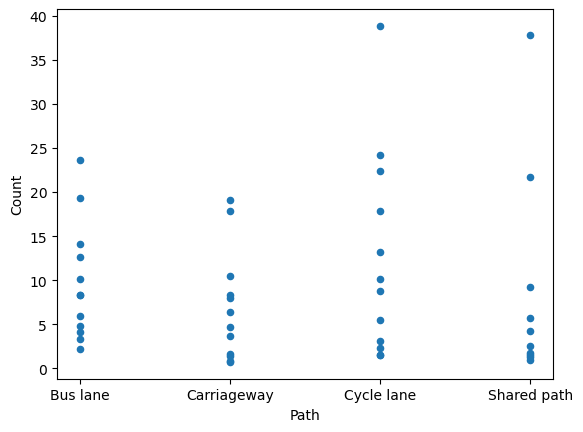

In [182]:
# draw scatter plot
count_summary.plot.scatter('Path', 'Count')


In [183]:
# get dummy variables
count_summary = pd.get_dummies(count_summary, columns = ['Path'], dtype = 'int')

# drop unnneccesary columns
count_summary = count_summary.drop(columns = ['Path_Carriageway'])

<Axes: >

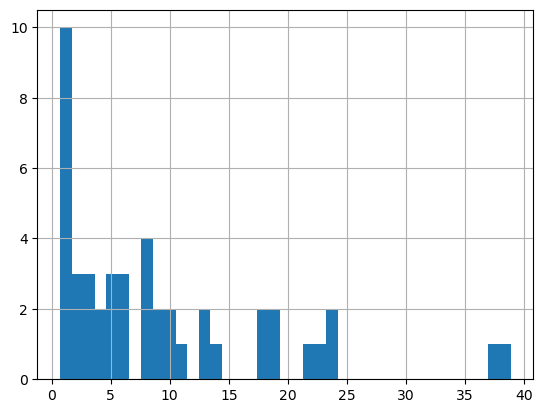

In [184]:
# plot the distribution of counts per 15 minutes
count_summary.Count.hist(bins = np.ceil(count_summary.Count.max()).astype(int))

## Doing the Advanced Regression



Text(0.5, 1.0, 'Correlation Matrix')

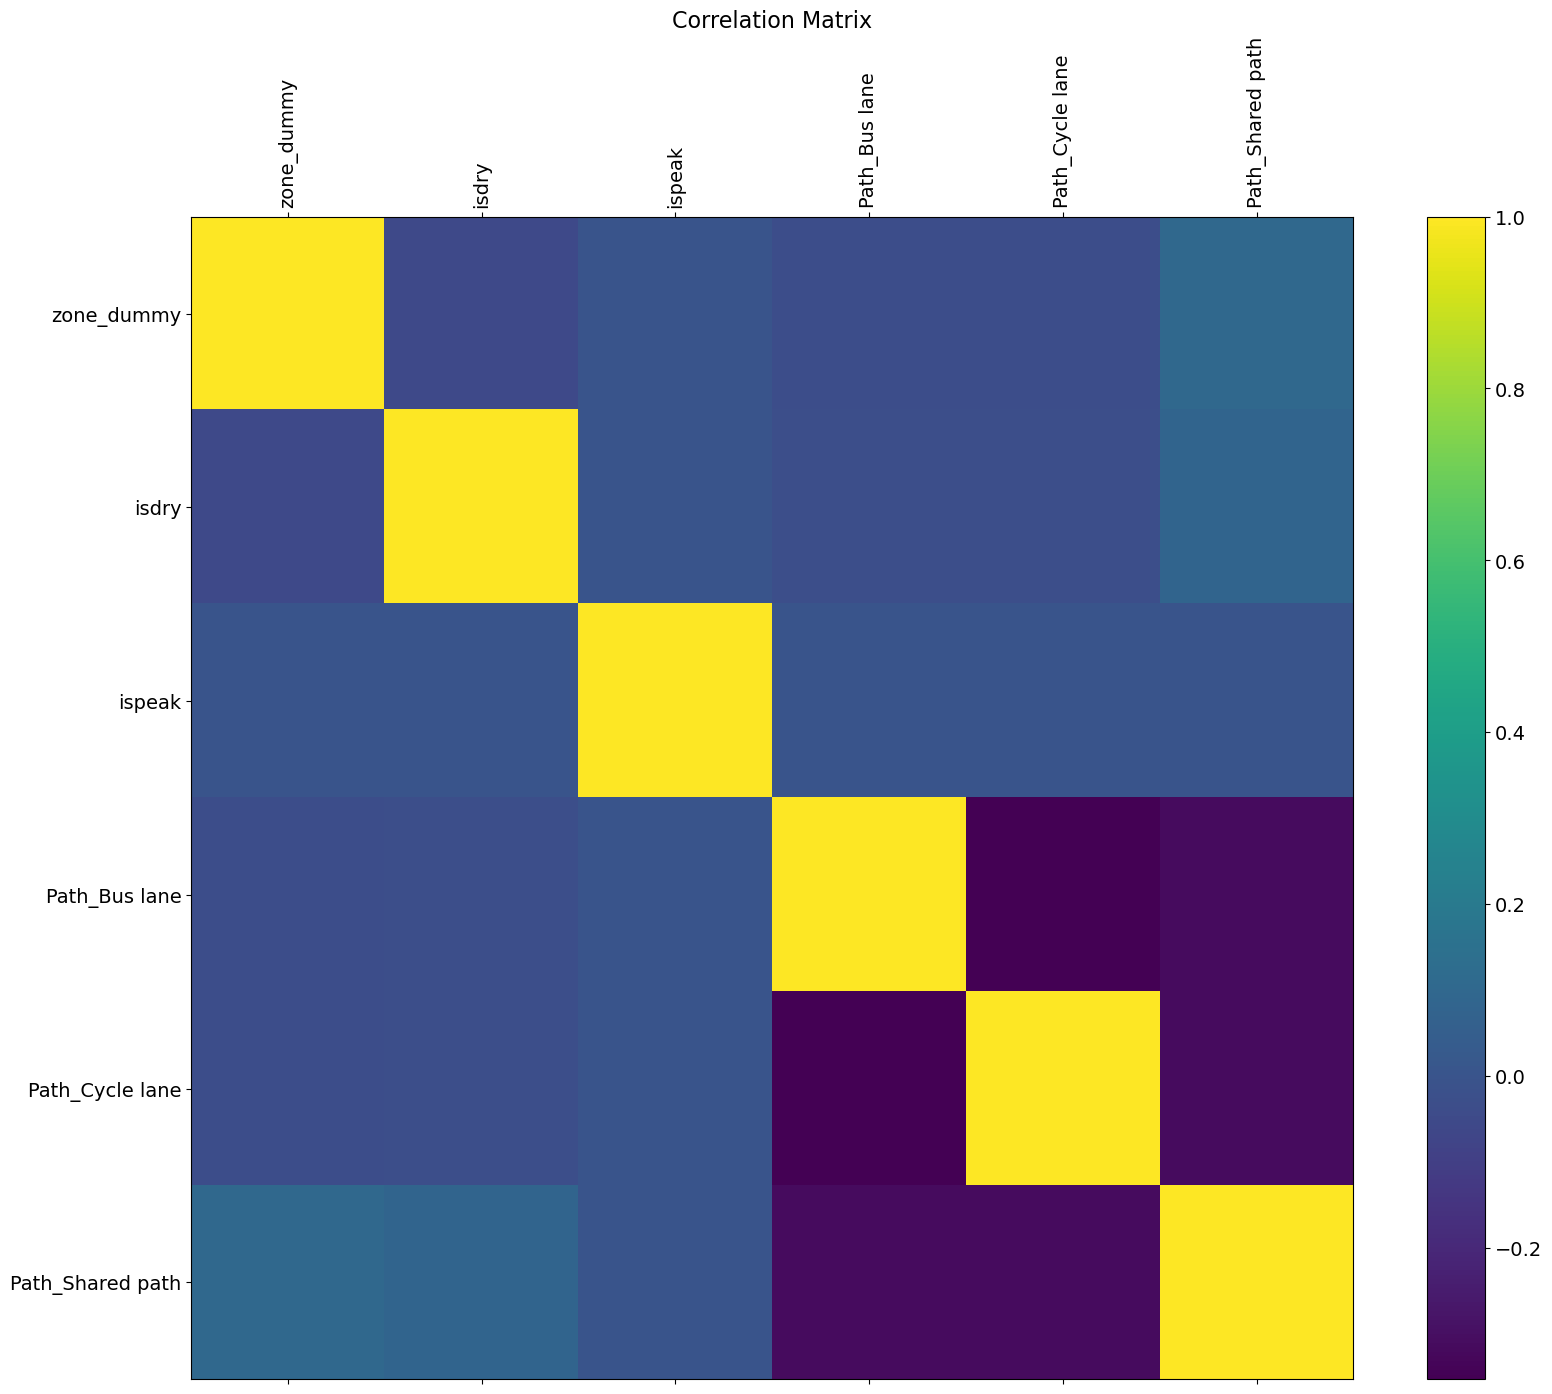

In [185]:
# check multi-colinearity
df = count_summary.copy().drop(columns = ['Count'])
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90) # rotation of xticks
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [186]:
# define function
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [187]:
print(count_summary.drop('Count', axis = 1).columns)
# using VIF on the bike_rental dataset
df_predictors_selected_VIF = drop_column_using_vif_(count_summary.drop('Count', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Index(['zone_dummy', 'isdry', 'ispeak', 'Path_Bus lane', 'Path_Cycle lane',
       'Path_Shared path'],
      dtype='object')
The columns remaining after VIF selection are:
Index(['zone_dummy', 'isdry', 'ispeak', 'Path_Bus lane', 'Path_Cycle lane',
       'Path_Shared path'],
      dtype='object')


In [188]:
model_bike_count = sm.OLS(endog=count_summary[['Count']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_bike_count.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     15.48
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           5.46e-09
Time:                        14:58:14   Log-Likelihood:                -139.23
No. Observations:                  46   AIC:                             292.5
Df Residuals:                      39   BIC:                             305.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.0649      2.200      4.121      0.000       4.616      13.514
zone_dummy          -7.5503      0.999     -7.561      0.000      -9.570      -5.530
isdry                3.0256      1.609      1.880      0.068      -0.229       6.280
ispeak               7.7642      1.599      4.856      0.000       4.530      10.998
Path_Bus lane        2.8231      2.213      1.275      0.210      -1.654       7.300
Path_Cycle lane      5.5170      2.213      2.493      0.017       1.040       9.994
Path_Shared path     2.9677      2.336      1.270      0.212      -1.758       7.694
==============================================================================
Omnibus:                        9.734   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.027
Skew:                           0.951   Prob(JB):                       0.0110
Kurtosis:                       4.046   Cond. No.                         7.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Discussion

The variables that fulfill $p<0.05$ are:

- `zone_dummy`: as we go outside, the density decreases
- `ispeak`: if peak, the traffic increases
- `Path_Carriageway`: considerably less cycles on carriageway compared to cycle lane
- `Path_Cycle`: considerably more cycles on cycle lane compared to other lane

On the other hand, these factors do not have significant impact:
- weather (really? $p=0.088$ suggests we are close, but still surprising)
- type of road
- bus lane / shared path

To Do: consider if these have an impact when we looked at them one by one. Maybe.


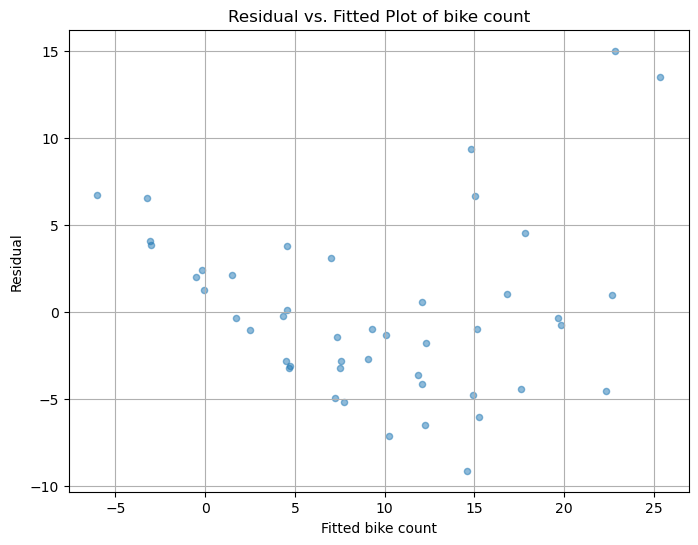

In [189]:
# residual analysis

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
plt.scatter(model_bike_count.fittedvalues, model_bike_count.resid, alpha = 0.5, s=20)
# adding title and labels
plt.xlabel('Fitted bike count')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of bike count')
# Adding grid lines
plt.grid(True)
plt.show()

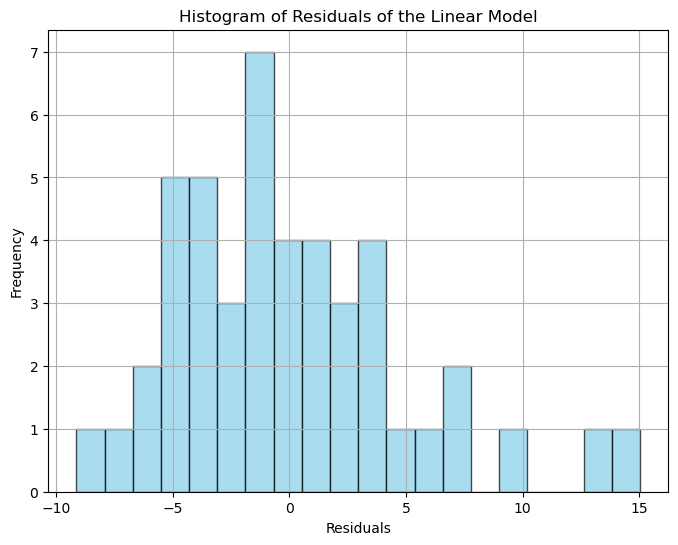

In [190]:
# Histogram of residuals

# Set the figure size
plt.figure(figsize=(8, 6))  

# Plotting the histogram
plt.hist(model_bike_count.resid, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of the Linear Model')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

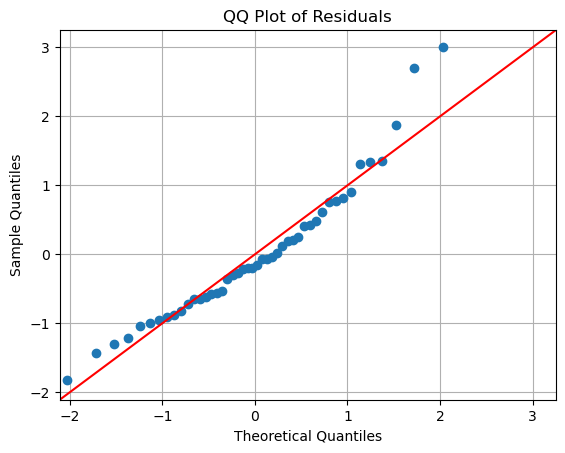

In [191]:
# (optional) the QQ plot of residuals
# More details: https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html
fig = sm.qqplot(model_bike_count.resid, fit=True, line="45")
plt.title('QQ Plot of Residuals')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()